In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy.spatial import Delaunay
from form_factor import *

In [2]:
# ---------------------------
# Bifrustum Vertex Generator
# ---------------------------
def bifrustum_verts(n, a, c, t):
    """
    Generate the 3D coordinates of a bifrustum shape (truncated bipyramid).

    Parameters:
    - n: int
        Number of sides in the base polygon (e.g., 5 for a pentagon).
    - a: float
        Circumradius of the base polygon.
    - c: float
        Half-height from center to apex (before truncation).
    - t: float
        Truncation ratio:
          t = 0 → sharp bipyramid,
          t = 1 → fully truncated to zero height.

    Returns:
    - verts: (3n, 3) np.ndarray
        Coordinates of vertices: base (z=0), upper (z=+), and lower (z=-).
    """
    angles = np.linspace(0, 2 * np.pi, n, endpoint=False)

    base = np.stack([a * np.cos(angles), a * np.sin(angles), np.zeros(n)], axis=1)
    a_t = a * t
    z_up = c * (1 - t)
    up = np.stack([a_t * np.cos(angles), a_t * np.sin(angles), np.full(n, z_up)], axis=1)
    down = np.stack([a_t * np.cos(angles), a_t * np.sin(angles), np.full(n, -z_up)], axis=1)

    verts = np.vstack([base, up, down])
    return verts

# ---------------------------
# Bifrustum Face Definition
# ---------------------------
def bifrustum_faces(n):
    """
    Generate polygonal face indices for a bifrustum.

    Parameters:
    - n: int
        Number of vertices in each polygon layer.

    Returns:
    - faces: list of lists of int
        Face vertex indices (quads and caps).
    """
    base = list(range(n))
    up = list(range(n, 2 * n))
    down = list(range(2 * n, 3 * n))

    faces = [up, down]  # Top and bottom caps

    for i in range(n):
        j = (i + 1) % n
        faces.append([base[i], base[j], up[j], up[i]])      # upper side
        faces.append([base[i], base[j], down[j], down[i]])  # lower side

    return faces

# ---------------------------
# Cube (111) Direction Vertices
# ---------------------------
def cube_111_vertices(scale=1.0):
    """
    Generate vertices along (111)-type directions of a cube.

    Parameters:
    - scale: float
        Scale factor (distance from origin to vertex).

    Returns:
    - verts: (8, 3) np.ndarray
        Array of vertices along ±(1,1,1) directions.
    """
    directions = list(product([-1, 1], repeat=3))
    return np.array(directions, dtype=float) * scale

# ================================================================
# SECTION: Mesh Visualization and Analysis
# ================================================================

# ---------------------------
# Plot Tetrahedra with Center Offset
# ---------------------------
def plot_tetrahedra_center_offset(verts, tetrahedra, offset=0.2):
    """
    Visualize tetrahedra with slight offset from their center to avoid overlap.

    Parameters:
    - verts: (N, 3) array of vertex coordinates
    - tetrahedra: (M, 4) array of tetrahedron vertex indices
    - offset: float
        Multiplier applied to center of each tetrahedron for visualization.
    """
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    for tet in tetrahedra:
        tet_verts = verts[tet]
        center = tet_verts.mean(axis=0)
        shifted = tet_verts + offset * center

        faces = [
            [shifted[0], shifted[1], shifted[2]],
            [shifted[0], shifted[1], shifted[3]],
            [shifted[0], shifted[2], shifted[3]],
            [shifted[1], shifted[2], shifted[3]],
        ]
        poly = Poly3DCollection(faces, alpha=0.5, edgecolor='k')
        poly.set_facecolor(np.random.rand(3,))
        ax.add_collection3d(poly)

    all_shifted = np.vstack([verts[tet] + offset * verts[tet].mean(axis=0) for tet in tetrahedra])
    max_range = (all_shifted.max(axis=0) - all_shifted.min(axis=0)).max() / 2.0
    mid = all_shifted.mean(axis=0)

    for axis, m in zip([ax.set_xlim, ax.set_ylim, ax.set_zlim], mid):
        axis(m - max_range, m + max_range)

    ax.set_box_aspect([1, 1, 1])
    plt.tight_layout()
    plt.show()

# ---------------------------
# Compute Volume of Tetrahedra
# ---------------------------
def compute_tetrahedra_volumes(verts, tetrahedra):
    """
    Compute volume of each tetrahedron.

    Parameters:
    - verts: (N, 3)
    - tetrahedra: (M, 4)

    Returns:
    - volumes: (M,) np.ndarray of positive volumes.
    """
    v0 = verts[tetrahedra[:, 0]]
    v1 = verts[tetrahedra[:, 1]]
    v2 = verts[tetrahedra[:, 2]]
    v3 = verts[tetrahedra[:, 3]]

    cross = np.cross(v1 - v0, v2 - v0)
    dot = np.einsum('ij,ij->i', cross, v3 - v0)
    volumes = np.abs(dot) / 6.0
    return volumes

# ---------------------------
# Fix Tetrahedron Orientations
# ---------------------------
def fix_tetrahedron_orientations(verts, tetrahedra):
    """
    Ensure all tetrahedra are right-handed (positive volume).

    Parameters:
    - verts: (N, 3)
    - tetrahedra: (M, 4)

    Returns:
    - corrected_tetrahedra: (M, 4)
    """
    corrected = tetrahedra.copy()

    for i, tet in enumerate(tetrahedra):
        v0, v1, v2, v3 = verts[tet]
        signed_vol = np.dot(np.cross(v1 - v0, v2 - v0), v3 - v0)
        if signed_vol < 0:
            corrected[i] = [tet[0], tet[2], tet[1], tet[3]]  # Swap to fix parity

    return corrected

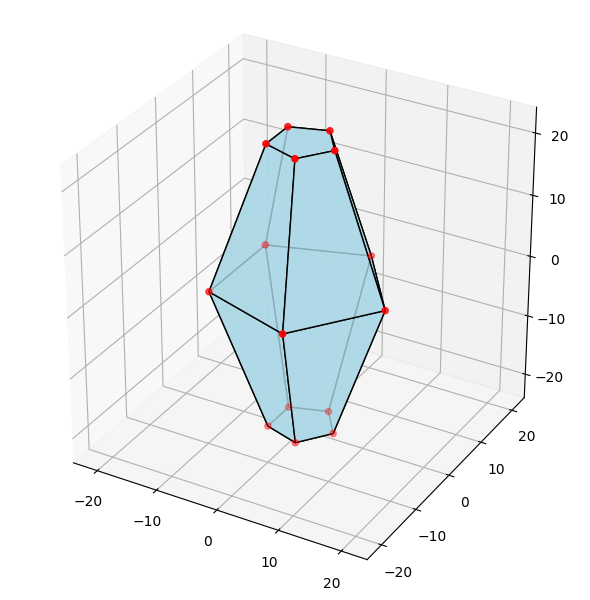

In [3]:
## Example usage

# Parameters
n = 5
a = 13.35
c = 37.4
t = 10.2 / 26.7

verts = bifrustum_verts(n, a, c, t)
faces = bifrustum_faces(n)

from scipy.spatial.transform import Rotation
# # Apply a random rotation
# rotation = Rotation.random()
# verts = rotation.apply(verts)

# Plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

poly3d = [[verts[idx] for idx in face] for face in faces]
ax.add_collection3d(Poly3DCollection(poly3d, facecolors='lightblue', linewidths=1, edgecolors='k', alpha=0.8))

ax.scatter(verts[:, 0], verts[:, 1], verts[:, 2], color='r', s=20)

# Set equal aspect
max_range = (verts.max(axis=0) - verts.min(axis=0)).max() / 2.0
mid = verts.mean(axis=0)
for axis, m in zip([ax.set_xlim, ax.set_ylim, ax.set_zlim], mid):
    axis(m - max_range, m + max_range)

ax.set_box_aspect([1,1,1])
plt.tight_layout()
plt.show()


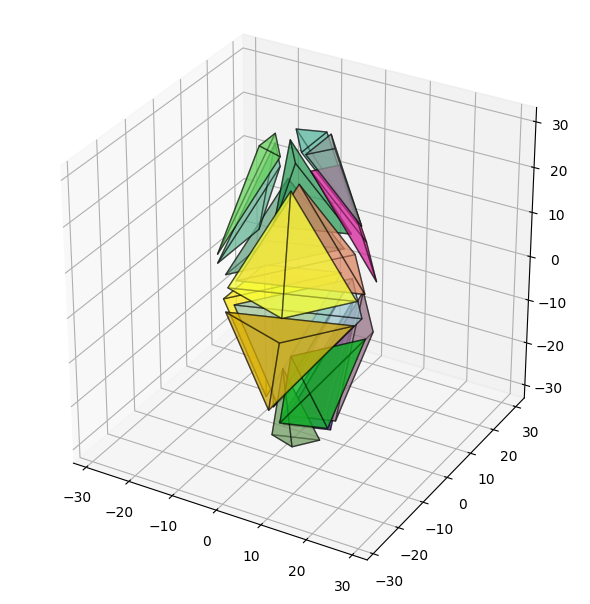

In [4]:
# Dissect the bifrustum into tetrahedra
delaunay = Delaunay(verts)
tetrahedra = delaunay.simplices

# Compute volumes of all tetrahedra
tetra_volumes = compute_tetrahedra_volumes(verts, tetrahedra)

# Filter out near-zero volume tetrahedra (threshold = 1e-6)
volume_threshold = 1e-6
valid_indices = np.where(tetra_volumes > volume_threshold)[0]

# Filter tetrahedra and volumes
filtered_tetrahedra = tetrahedra[valid_indices]
filtered_volumes = tetra_volumes[valid_indices]

total_volume = np.sum(filtered_volumes)

# Apply orientation correction to the tetrahedral mesh
tetrahedra_fixed = fix_tetrahedron_orientations(verts, filtered_tetrahedra)

# Visualize the result
plot_tetrahedra_center_offset(verts, tetrahedra_fixed, offset=0.5)

In [5]:
n_grid = 100
qx = np.linspace(-1, 1, n_grid)*0.5
qy = 0
qz = np.linspace(-1, 1, n_grid)*0.5

q_grid = np.meshgrid(qx, qy, qz)

I_q_grid_flat = scattering_function_tetrahedron(verts, tetrahedra_fixed, q_grid)
I_q = I_q_grid_flat.reshape([n_grid,n_grid])

Flattening q_grid...
Time taken: 0.0004668235778808594 seconds
Calculating tetrahedron volumes...
Time taken: 1.8596649169921875e-05 seconds
Calculating orthogonal tetrahedra form factor...
Time taken: 0.033167362213134766 seconds
Calculating scattering function I_q...
Time taken: 1.8358230590820312e-05 seconds
Scattering function calculation complete.


/SNS/users/ccu/Documents/simplex_scattering/form_factor.py:27: RuntimeWarning: divide by zero encountered in divide
  scattering_amplitude = DENSITY * det_T * (1j * np.exp(1j * Q3) / (Q3 * (Q3 - Q2) * (Q3 - Q1)) +
/SNS/users/ccu/Documents/simplex_scattering/form_factor.py:29: RuntimeWarning: divide by zero encountered in divide
  1j * np.exp(1j * Q1) / (Q1 * (Q1 - Q2) * (Q1 - Q3)) -
/SNS/users/ccu/Documents/simplex_scattering/form_factor.py:27: RuntimeWarning: invalid value encountered in multiply
  scattering_amplitude = DENSITY * det_T * (1j * np.exp(1j * Q3) / (Q3 * (Q3 - Q2) * (Q3 - Q1)) +
/SNS/users/ccu/Documents/simplex_scattering/form_factor.py:28: RuntimeWarning: divide by zero encountered in divide
  1j * np.exp(1j * Q2) / (Q2 * (Q2 - Q1) * (Q2 - Q3)) +


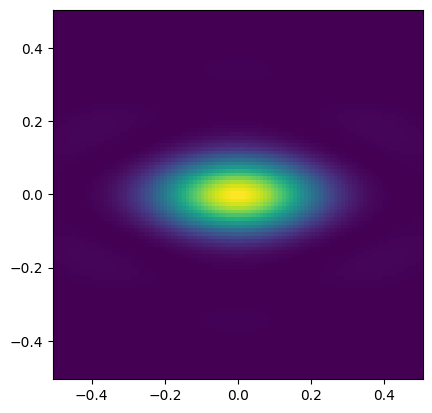

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111)

# pcolor plot of the scattering function
qx_plot, qy_plot = np.meshgrid(qx, qz)
I_q_plot = I_q/total_volume**2
ax.pcolor(qx_plot, qy_plot, I_q_plot.T, cmap='viridis', vmax=1, vmin=0)

ax.set_aspect('equal')